In [ ]:
%matplotlib inline

from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

# NBER recessions
from pandas_datareader.data import DataReader

usrec = DataReader(
    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)
)

We here try to replicate the regime switching model mentioned by Hamilton (1989). The model follows AR of order 4.

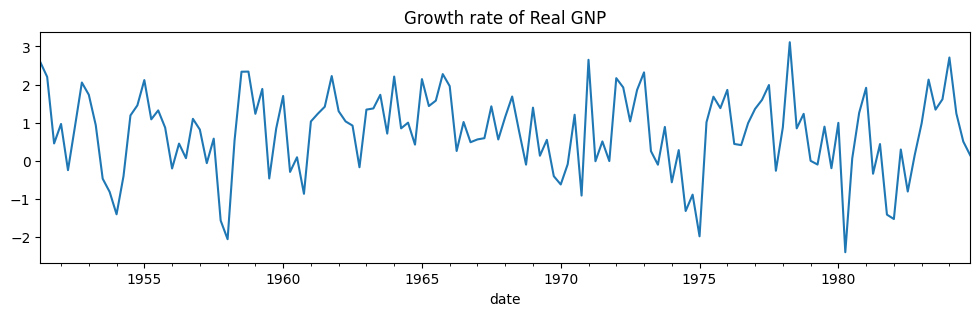

In [ ]:
import requests
import shutil


def download_file(url):
    local_filename = url.split("/")[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, "wb") as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename


filename = download_file("https://www.stata-press.com/data/r14/rgnp.dta")
# Get the RGNP data to replicate Hamilton

dta = pd.read_stata(filename).iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title="Growth rate of Real GNP", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(
    dta_hamilton, k_regimes=2, order=4, switching_ar=False
)
res_hamilton = mod_hamilton.fit()

In [ ]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Fri, 10 Oct 2025   AIC                            380.527
Time:                          17:47:39   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Please refer to the project report for the foundations of the filter and smoother.

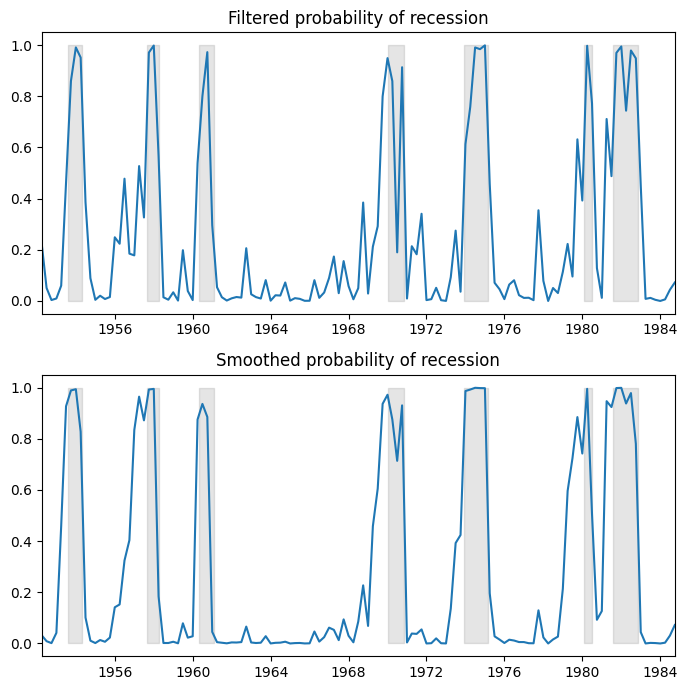

In [ ]:
fig, axes = plt.subplots(2, figsize=(7, 7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title="Filtered probability of recession")

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title="Smoothed probability of recession")

fig.tight_layout()

In [ ]:
print(res_hamilton.expected_durations)

[ 4.07604745 10.42589386]


From the tpm we found, we calculate the expected duration of a recession versus an expansion. Here its expected that a recession will last about 1 year (4 quarters) and an expansion lasts about 2.5 years.

Transition Probability Matrix (TPM):


To Regime 0 (Recession)  To Regime 1 (Expansion)
From Regime 0 (Recession)                   0.7547                   0.2453
From Regime 1 (Expansion)                   0.0959                   0.9041


Expected Duration of Regime 0 (Recession): 4.08 quarters
Expected Duration of Regime 1 (Expansion): 10.43 quarters


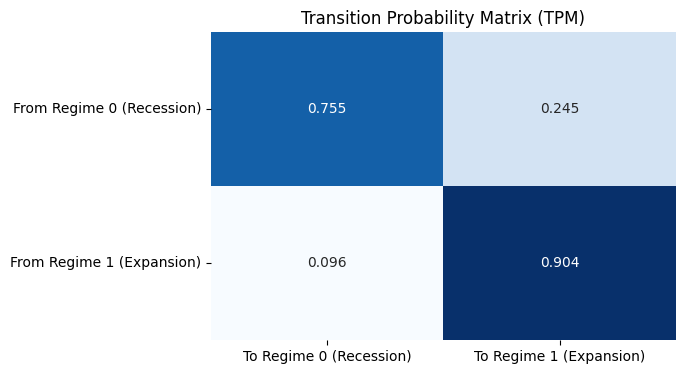

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract transition probabilities from model
p00 = res_hamilton.params['p[0->0]']
p10 = res_hamilton.params['p[1->0]']

# Construct transition matrix
tpm = pd.DataFrame([
    [p00, 1 - p00],
    [p10, 1 - p10]
],
columns=['To Regime 0 (Recession)', 'To Regime 1 (Expansion)'],
index=['From Regime 0 (Recession)', 'From Regime 1 (Expansion)'])

print("Transition Probability Matrix (TPM):")
display(tpm.round(4))

# Expected durations
D0 = 1 / (1 - p00)
D1 = 1 / (1 - (1 - p10))
print(f"\nExpected Duration of Regime 0 (Recession): {D0:.2f} quarters")
print(f"Expected Duration of Regime 1 (Expansion): {D1:.2f} quarters")

# Heatmap visualization
plt.figure(figsize=(6,4))
sns.heatmap(tpm, annot=True, fmt=".3f", cmap="Blues", cbar=False)
plt.title("Transition Probability Matrix (TPM)")
plt.show()
